In [14]:
install.packages("ggbeeswarm")

also installing the dependencies 'beeswarm', 'vipor'




package 'beeswarm' successfully unpacked and MD5 sums checked
package 'vipor' successfully unpacked and MD5 sums checked
package 'ggbeeswarm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpgfvLBs\downloaded_packages


In [15]:
# Import packages

# Visualization packages:
library(ggplot2)
library(ggbeeswarm)

In [1]:
# Set data path
setwd("C:/Users/user/OneDrive - Erasmus University Rotterdam/Documents/01 Postgrad/02 Spring semester/06 Business Analytics for International Managers/rsm_data_analytics")

In [8]:
# Import the CSV file 
df1 <- read.csv("ebi_customers.csv")
df2 <- read.csv("ebi_exp_customers.csv")
df <- rbind(df1, df2)

In [16]:
head(df)

customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0


# 1: Exploratory Data Analysis

__1.1: What is the overall rate of customer churn in the dataset?__

In [20]:
churn_rate <- mean(df$churn)
churn_rate_pct <-paste0(round(churn_rate*100,2),"%")
cat("The overall rate of customer churn is:",churn_rate_pct)

The overall rate of customer churn is: 20.37%

__1.2: How does the rate of customer churn vary by demographic variables such as age, gender, etc.? How does it vary across the countries?__

In [27]:
churn_rate_by_gender <- aggregate(churn ~ gender, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
churn_rate_by_country <- aggregate(churn ~ country, df, function(x) round(100 * sum(x) / length(x), 2))
                                  
cat("Churn rate by gender:\n")
print(churn_rate_by_gender)
cat("\n")                         
cat("Churn rate by country:\n")
print(churn_rate_by_country)

Churn rate by gender:
  gender churn
1 Female 25.07
2   Male 16.46

Churn rate by country:
  country churn
1  France 16.15
2 Germany 32.44
3   Spain 16.67


Women have, on average, a higher churn rate then men. Germans have, on average, a higher churn rate than French and Spanish.

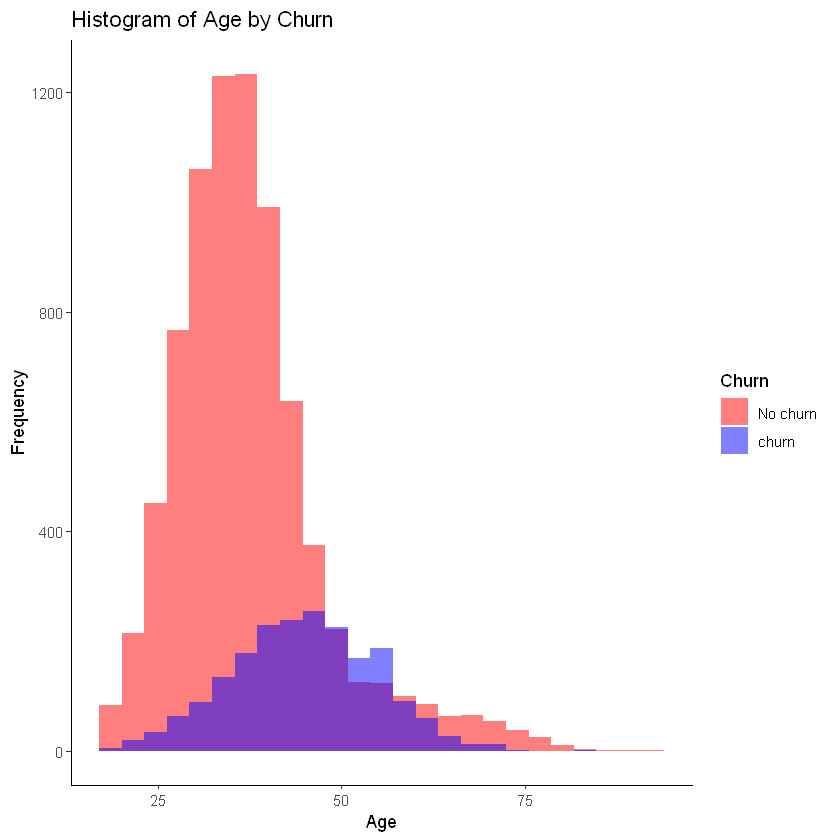

In [23]:
# Plot age distribution by churn vs. no-churn
ggplot(df, aes(x = age, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Age by Churn", x = "Age", y = "Frequency", fill = "Churn") +
  theme_classic()

In [40]:
age_brackets <- cut(df$age, breaks = seq(15, 95, by = 5), right = FALSE)
churn_rate_by_age_bracket <- aggregate(churn ~ age_brackets, df, function(x) round(100 * sum(x) / length(x), 2))
cat("Churn rate by country:\n")
print(churn_rate_by_age_bracket)

Churn rate by country:
   age_brackets churn
1       [15,20)  6.12
2       [20,25)  9.07
3       [25,30)  7.09
4       [30,35)  8.15
5       [35,40) 13.30
6       [40,45) 23.67
7       [45,50) 43.39
8       [50,55) 56.92
9       [55,60) 54.78
10      [60,65) 42.62
11      [65,70) 21.37
12      [70,75) 14.43
13      [75,80)  0.00
14      [80,85)  9.09
15      [85,90)  0.00
16      [90,95)  0.00


Customers in the age group between 45 and 65 have the highest churn rate. 

__1.3: Report interesting patterns that you find in the dataset.__

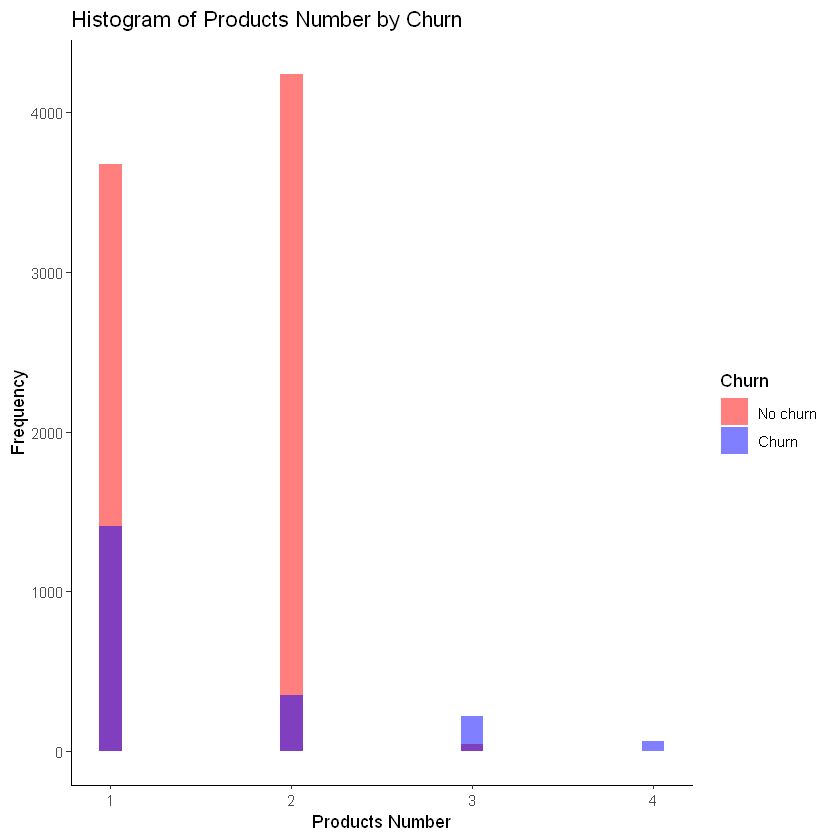

In [27]:
# Plot product number distribution by churn vs. no-churn
ggplot(df, aes(x = products_number, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Products Number by Churn", x = "Products Number", y = "Frequency", fill = "Churn") +
  theme_classic()

In [45]:
# Separate out ages for two groups
products_churn <- df$products_number[df$churn == 1]
products_no_churn <- df$products_number[df$churn == 0]

# Calculate difference in mean and median
mean_diff_products <- mean(products_no_churn) - mean(products_churn)
median_diff_products <- median(products_no_churn) - median(products_churn)
cat("Mean diff in number of products:", mean_diff_products, "\n")
cat("Median diff in number of products:", median_diff_products, "\n")

# Run t-test
ttest <- t.test(products_churn, products_no_churn)
pval <- ttest$p.value
cat("P-value for number of products vs churn:", pval, "\n")

Mean diff in number of products: 0.0690586 
Median diff in number of products: 1 
P-value for number of products vs churn: 0.0002185849 


There seems to be a statistically significant relationship between the number of products and churn. Customers that have a higher number of products are less likely to churn. Customers with 

In [48]:
subset(df, products_number == 4)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
65,15703793,738,Germany,Male,58,2,133745.44,4,1,0,28373.86,1
1115,15610383,628,France,Female,46,1,46870.43,4,1,0,31272.14,1
1307,15670374,819,Germany,Female,49,1,120656.86,4,0,0,166164.30,1
1324,15625824,596,Spain,Male,30,6,121345.88,4,1,0,41921.75,1
1519,15605279,792,France,Male,50,9,0.00,4,1,1,194700.81,1
1669,15664754,640,Germany,Male,39,9,131607.28,4,0,1,6981.43,1
1895,15603851,704,France,Male,32,7,127785.17,4,0,0,184464.70,1
1962,15791700,773,Germany,Male,47,2,118079.47,4,1,1,143007.49,1


In [32]:
# create contingency table to test relationship between churn and membership status
table_active_member <- table(df$active_member, df$churn)
rownames(table_active_member) <- c("Non-Active Member", "Active Member")
colnames(table_active_member) <- c("Not Churned", "Churned")

# run chi-squared test and print p-value
test <- chisq.test(table_active_member)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
rownames(expected) <- rownames(table_active_member)
colnames(expected) <- colnames(table_active_member)
print(expected)

[1] 8.785858e-55
                   
                    Not Churned   Churned
  Non-Active Member    3861.259  987.7413
  Active Member        4101.741 1049.2587


There is a statistically significant relationship between membership status and churn. Non-active members are more likely to churn than active members. 

__1.4: Further non-significant findings:__

In [30]:
# create contingency table to test relationship between churn and credit card ownership
table_credit_card <- table(df$credit_card, df$churn)

# run chi-squared test and print p-value
test <- chisq.test(table_credit_card)
pval <- test$p.value
print(pval)

# print expected values
expected <- test$expected
print(expected)

[1] 0.4923724
   
           0         1
  0 2345.104  599.8965
  1 5617.896 1437.1035


No statistically significant relationship between churn rate and credit card ownership as p-value is not leas than the significance level of 5%

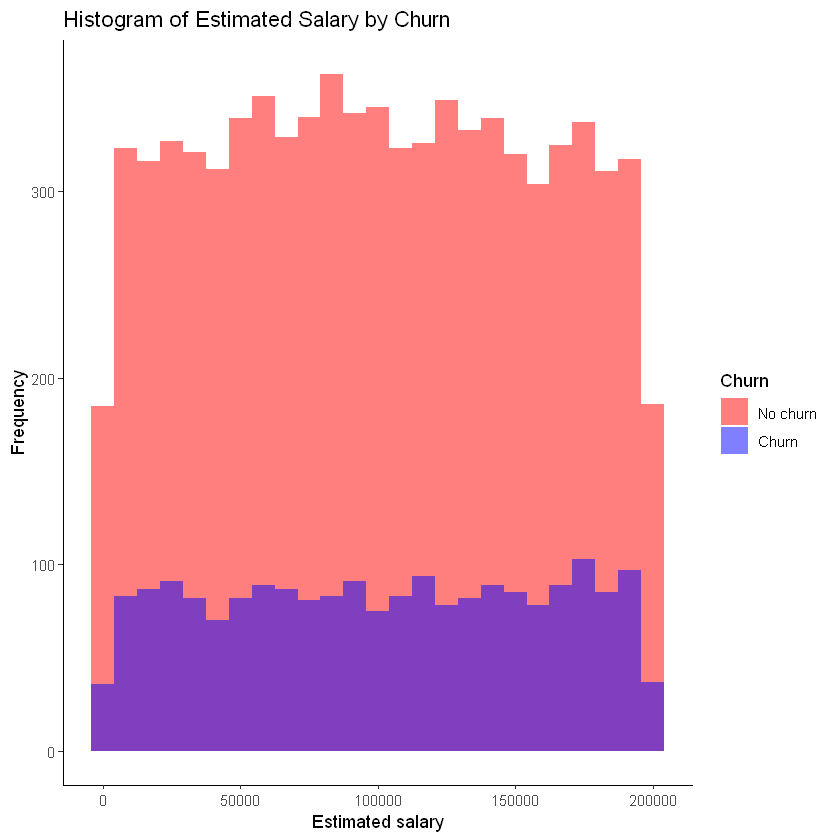

In [26]:
# Plot estimated salary distribution by churn vs. no-churn
ggplot(df, aes(x = estimated_salary, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Estimated Salary by Churn", x = "Estimated salary", y = "Frequency", fill = "Churn") +
  theme_classic()

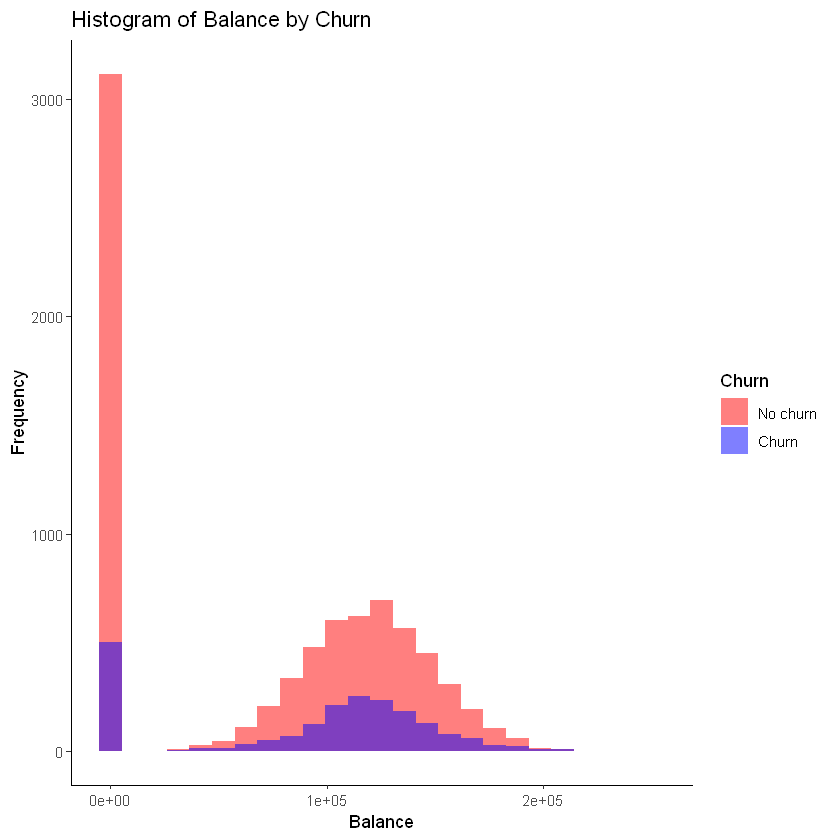

In [25]:
# Plot balance distribution by churn vs. no-churn
ggplot(df, aes(x = balance, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Balance by Churn", x = "Balance", y = "Frequency", fill = "Churn") +
  theme_classic()

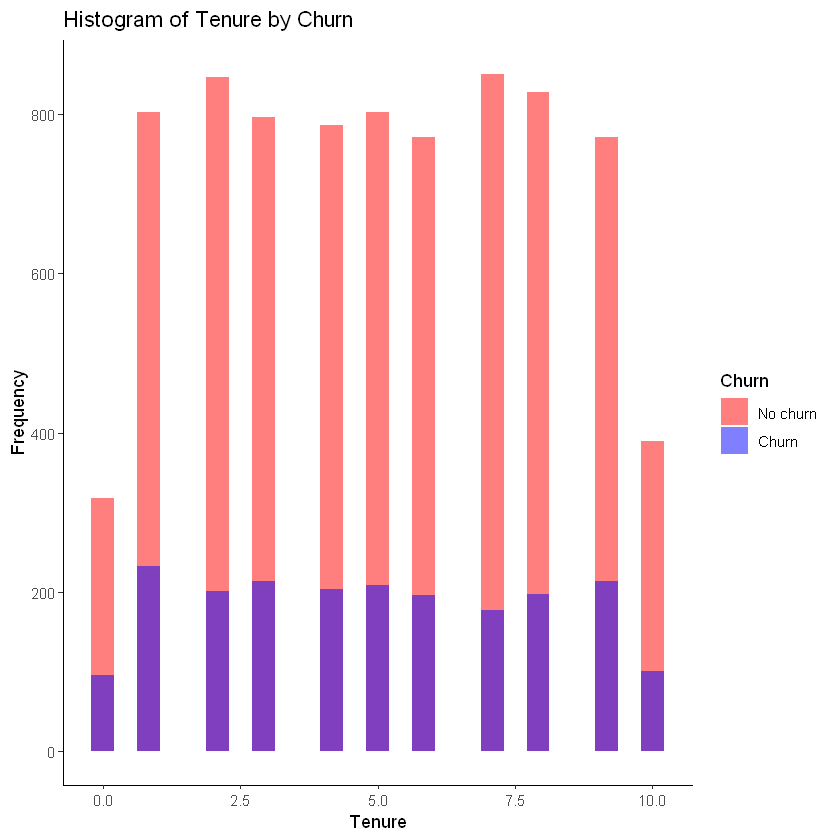

In [24]:
# Plot tenure distribution by churn vs. no-churn
ggplot(df, aes(x = tenure, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Tenure by Churn", x = "Tenure", y = "Frequency", fill = "Churn") +
  theme_classic()

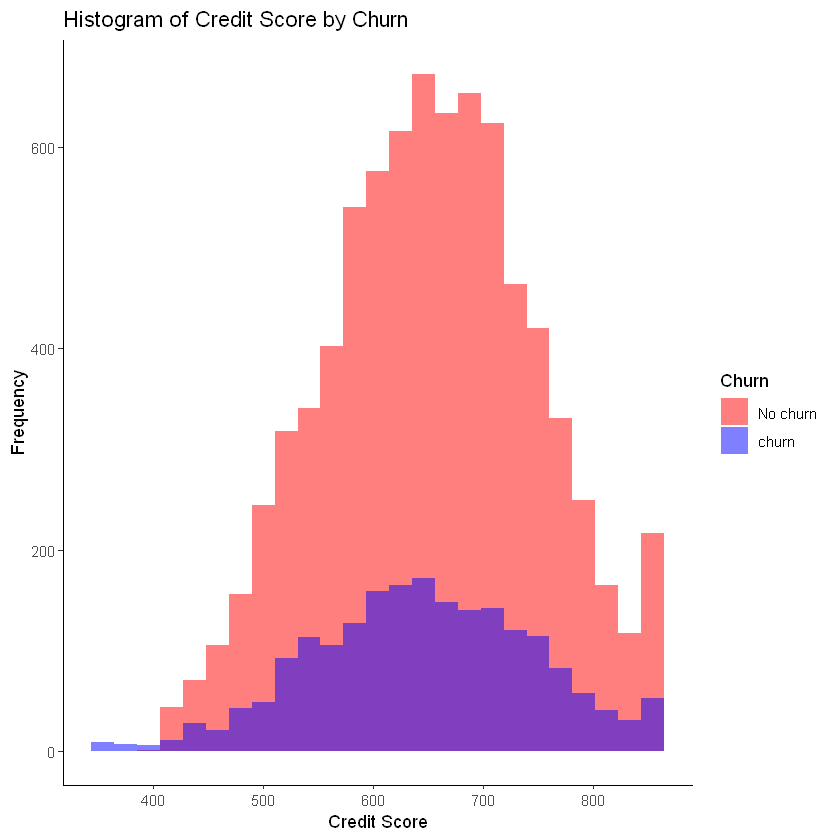

In [22]:
# Plot credit score distribution by churn vs. no-churn
ggplot(df, aes(x = credit_score, fill = as.factor(churn))) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 25) +
  scale_fill_manual(values = c("red", "blue"), labels=c('No churn', 'Churn')) +
  labs(title = "Histogram of Credit Score by Churn", x = "Credit Score", y = "Frequency", fill = "Churn") +
  theme_classic()

# 2: Data Pre-Processing

Are there any outliers/anomaly in the data that need to be addressed? 
Are there variables in the dataset that will not be used in the analysis? Remove them. 
Are there categorical variables in the dataset? 
Should you convert those variables to numerical?

# 3: Model Building

Which variables are the strongest predictors of customer churn? 
How did you conclude that these are the strongest predictors? 
How do different model evaluation metrics (e.g., accuracy, precision, recall) vary for different models? 
Which model would you use for predicting customer churn?

# 4: Recommendations

Based on your analysis, develop 3 recommendations that will help EBI to better manage customer churn. Explain the rationale behind those 3 recommendations. • EBI has formulated a list of a subset of its current customers (see the dataset “ebi_exp_customers.csv” to answer this question) and would like to use your prediction model to take proactive measures to retain these customers. Specifically, the bank would target the customers (say, via telemarketing) who have high likelihood of churn. • Use your prediction model to predict the likelihood of churn for each customer in the dataset. • Suppose that the value of retaining a customer is €5 while the cost incurred by the bank to avoid a customer from churning is €1. How many and which customers from the dataset (“ebi_exp_customers.csv”) would you recommend the bank to target to maximize the total expected profit from this proactive targeting experiment? How would your answer change if the value of retaining a customer goes up to €10? Explain your computation